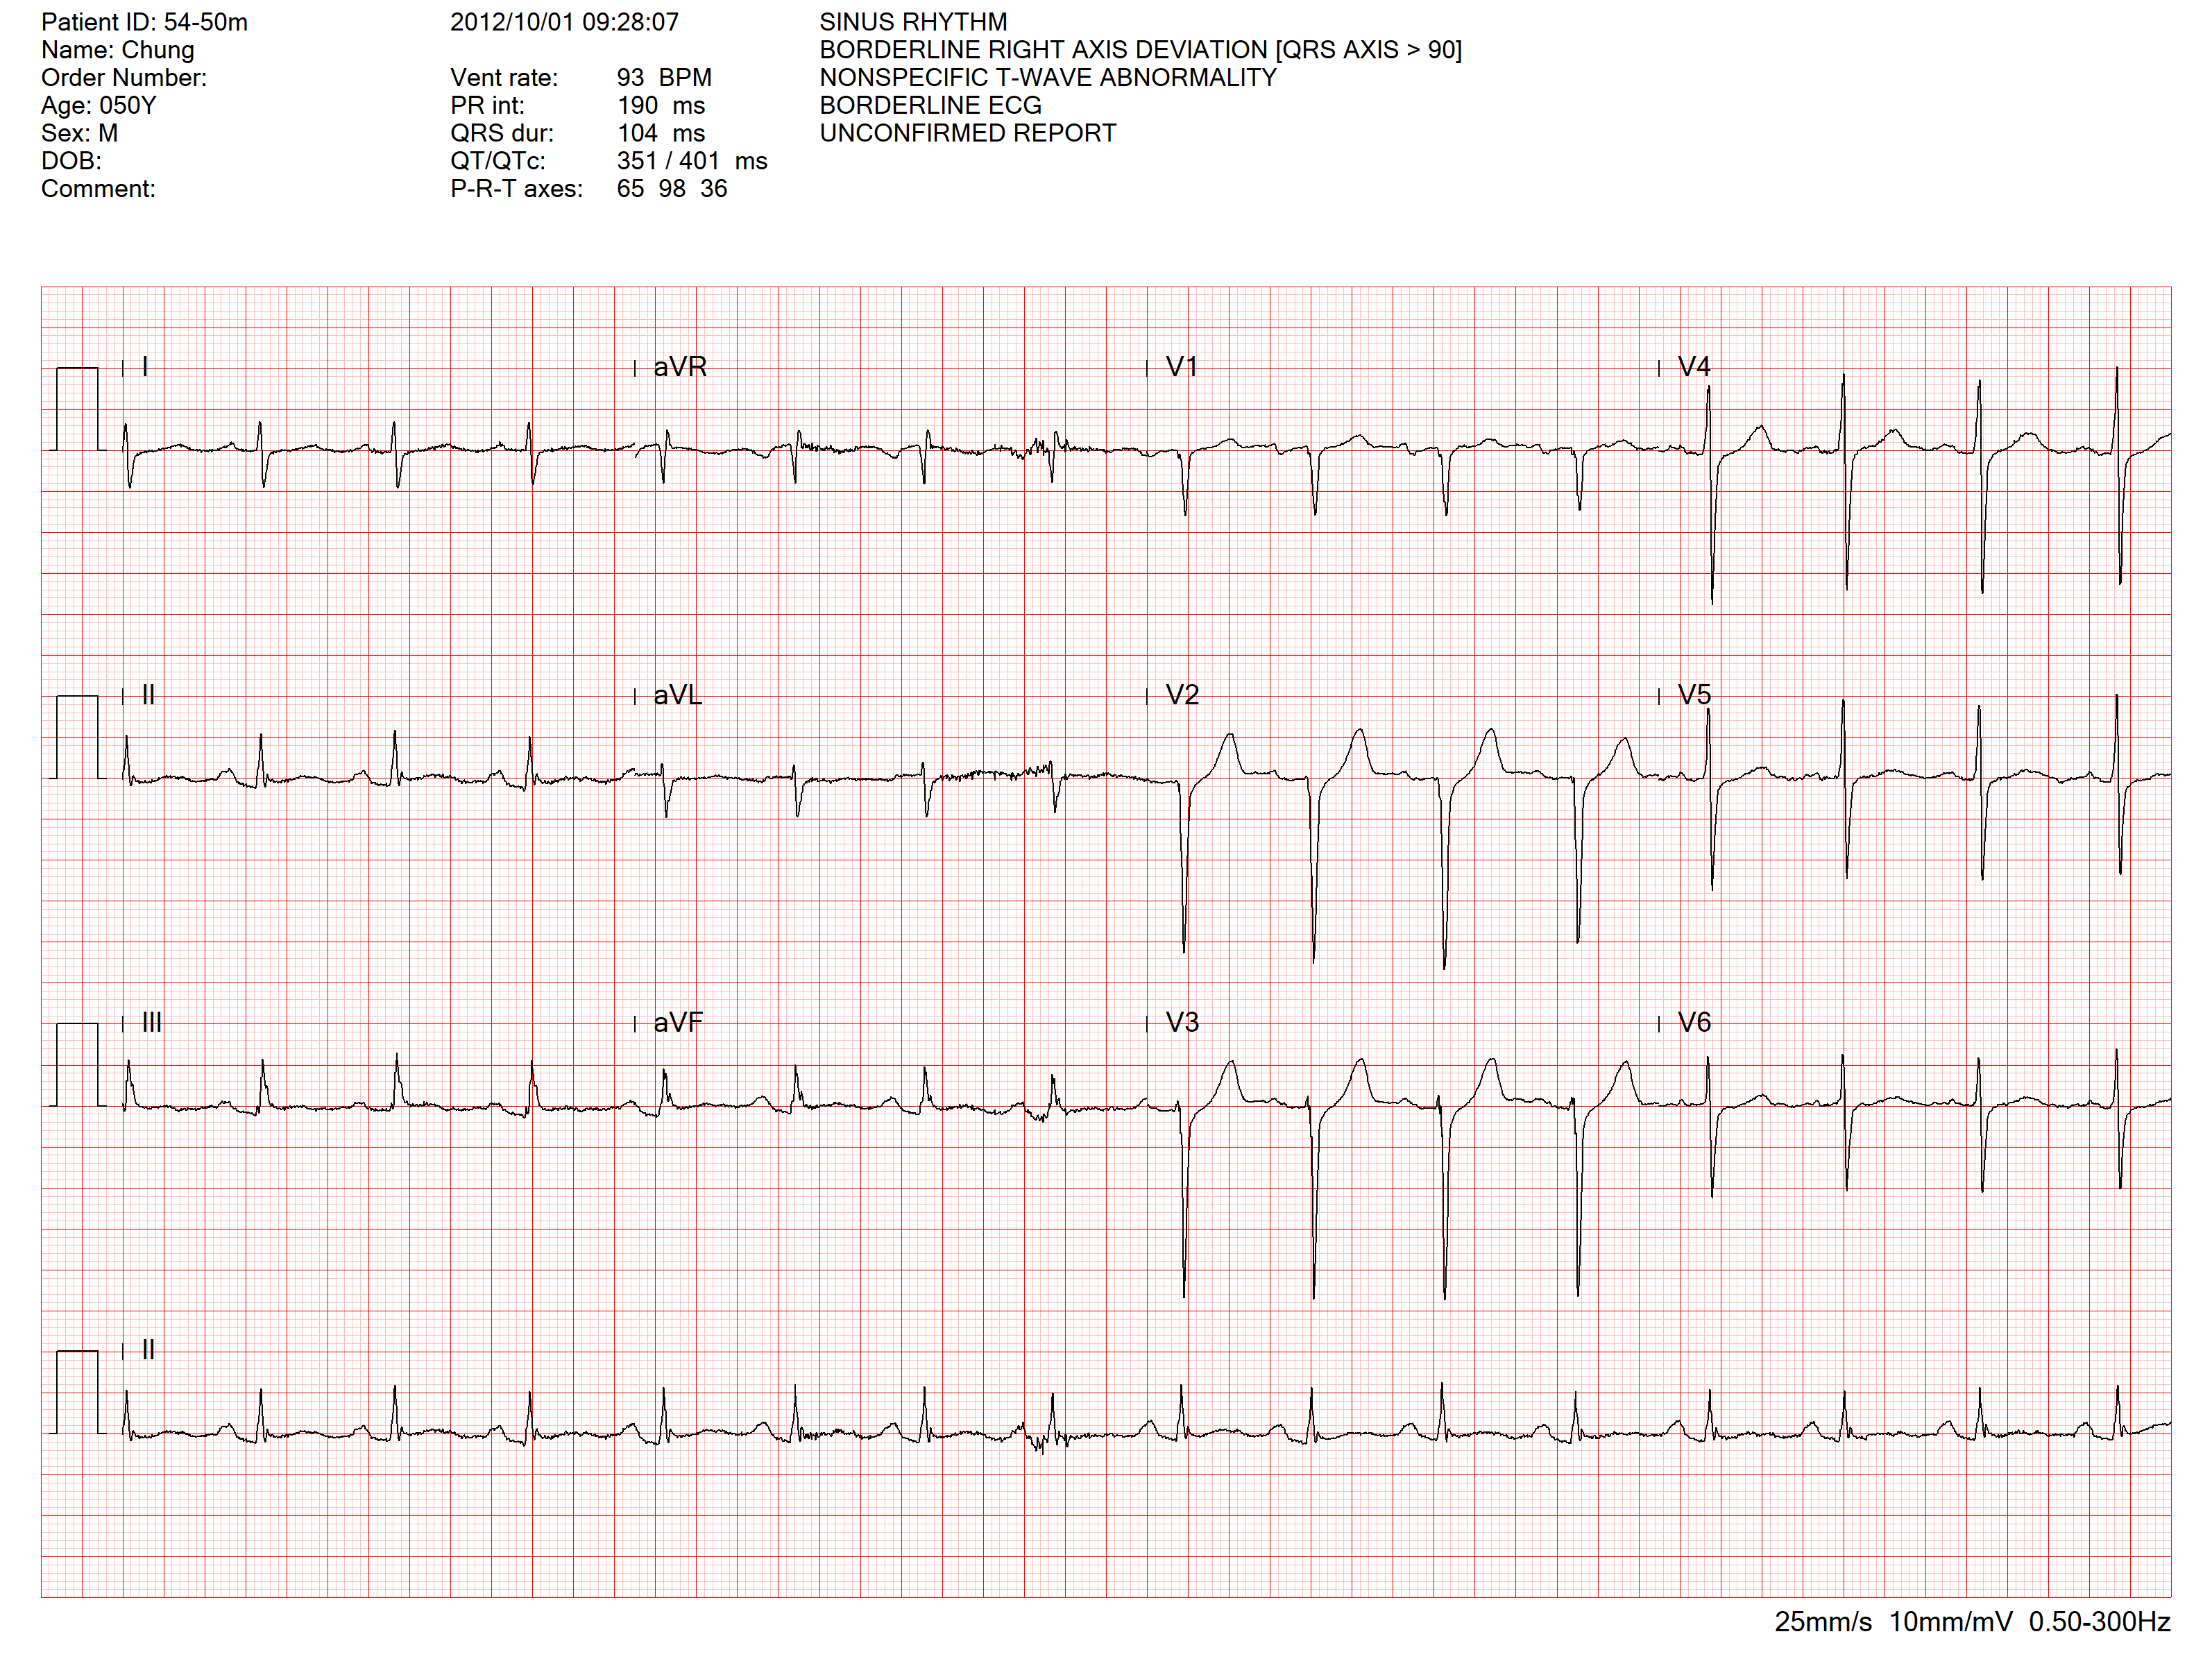

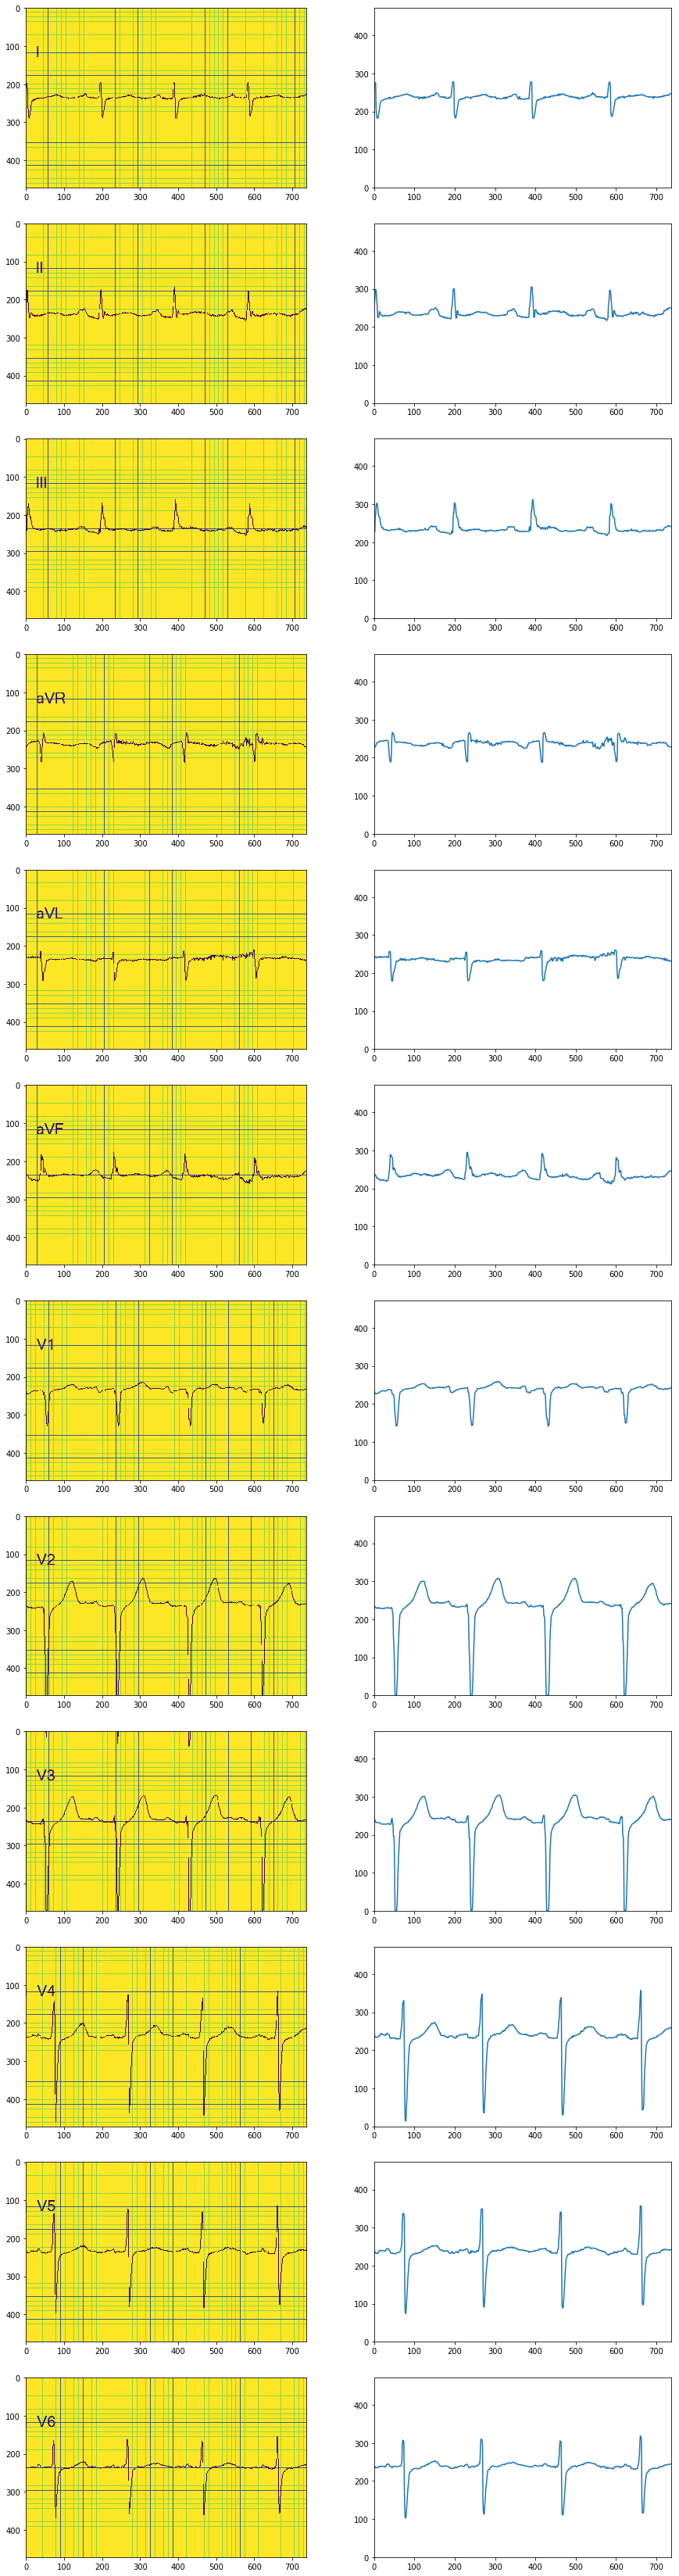

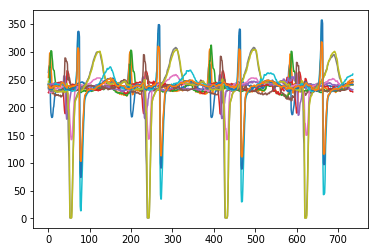

In [20]:
import pandas as pd
import os, sys
import numpy as np
import math
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image
import PIL
import s3fs 

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def dpDdecode(img, row, column, side):
    reward= np.zeros((row,column))
    prev= np.zeros((row,column))
    #print(prev.shape)
    for j in range(0,row):  # for each reward
        prev[j,0]=0;
        if img[j,0] < 1 :
            reward[j,0]=1
        else:
            reward[j,0]=0
        #display(reward[:,0])        

    columnTrace=column
    #columnTrace=4
    for i in range(1, columnTrace):  # for each stage
        for j in range(0,row):  # for each reward
        #for j in range(1,row-1):  # for each reward
            if img[j,i] > 1 : # white
                reward[j,i] = reward[j,i-1] 
                prev[j,i] =j #debug of edge :0
            else: #black
                #newReward=np.zeros([row],dtype=float)
                
                #newReward=reward[:,i-1]
                newReward=np.array(reward[:,i-1], copy=True)
                imgstrip=img[:,i]*img[:,i-1]
                #print(imgstrip.size)
                #print('pixel at img[{},{}]'.format)
                #print(newReward)
                for k in range(max(j-side,0),min(j+side,row)):
                    
                    
                    if j>k:
                        newReward[k]=newReward[k]+(1+abs(j/row-0.5)*0.1)/(np.count_nonzero(imgstrip[k:j]!=0)+1)#+abs(j/row-0.5)#-np.count_nonzero(imgstrip[k:j]!=0)/row*1000+ abs(j/row-0.5)
                        #newReward[k]=newReward[k]+1
                    else:
                        newReward[k]=newReward[k]+(1+abs(j/row-0.5)*0.1)/(np.count_nonzero(imgstrip[j:k]!=0)+1)#+abs(j/row-0.5)#-np.count_nonzero(imgstrip[j:k]!=0)/row*1000+ abs(j/row-0.5)
                        #newReward[k]=newReward[k]+1
                #print(newReward)
                absoluteMaxIndex=np.argmax(newReward)
                maxreward=newReward[absoluteMaxIndex]
                #print('{},{} : maxreward={}'.format(i,j,maxreward))
                reward[j,i] = maxreward
                prev[j,i] = absoluteMaxIndex
                '''
                relativeMaxIndex=np.argmax(reward[max(j-side,0):min(j+side,row),i-1])
                        #print(relativeMaxIndex)
                absoluteMaxIndex=max(j-side,0)+relativeMaxIndex
                maxreward=(reward[absoluteMaxIndex,i-1])
                reward[j,i] =1+ abs(j/row-0.5) + maxreward 
                prev[j,i] = absoluteMaxIndex
                '''
                #newReward=np.zeros([row],dtype=float)
                #for kk in range(max(j-side,0),min(j+side,row)):
                #    newReward[kk]=reward[kk,i-1]+
                    
                #print(maxreward)

                #for k in range(max(j-side,0),min(j+side,row)):
                #relativeMaxIndex=np.argmax(reward[max(j-side,0):min(j+side,row),i-1])
                    #print(relativeMaxIndex)
                #absoluteMaxIndex=max(j-side,0)+relativeMaxIndex
                #maxreward=(reward[max(j-side,0)+relativeMaxIndex,i-1])
                    #print(maxreward)

                
    # traceback
    #display(reward[:,columnTrace-1])        
    finalMaxIndex=np.argmax(reward[:,columnTrace-1])
    #display(reward[finalMaxIndex,columnTrace-1])
    tmpIndex=finalMaxIndex
    #print(finalMaxIndex)
    data_r=np.zeros(columnTrace)
    data_r[columnTrace-1]=row-tmpIndex

        
    for i in range(columnTrace-1, 0, -1):  # for each stage
        #print(tmpIndex)
        #print(reward[tmpIndex,i])
        tmpIndex=int(prev[tmpIndex,i])
        data_r[i-1]=row-tmpIndex
    return data_r


def ecg_parser(path,rowOffset, columnOffset, h, w):
    # open it directly
    fs = s3fs.S3FileSystem()
    with fs.open(path) as f:
        im = Image.open(f)
        display(im)
    '''
    im = Image.open(path)
    display(im)
    '''
    #im = Image.open(path)
    pix_color = np.array(im)
    pix_gray = rgb2gray(pix_color) 
    waves = np.zeros((w,12))


#Matthew : 737 or 738 relate to end point of the wave
#Matthew : side is the scan range , too small will lead broken line and forgeten pattern
    #from matplotlib.pyplot import figure
    #figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    f, axs = plt.subplots(2,12,figsize=(15,60))

    for ii in range(0,4):
        for jj in range(0,3):
            #print(rowOffset+472*jj)
            #print(columnOffset+737*ii)
            #print(pix_gray.shape)
            top=int(rowOffset+(h*jj))
            down=int(rowOffset+h*(jj+1))
            left=int(columnOffset+(w*ii))
            right=int(columnOffset+w*(ii+1))
            #print(top)
            #print(down)
            #print(left)
            #print(right)
            
            subImg=pix_gray[top:down,left:right]
            plt.subplot(12,2,(ii*3+jj)*2+1)
            #plt.subplot(1,2,1)
            plt.imshow(subImg)
            
            plt.subplot(12,2,(ii*3+jj)*2+1+1)
            #plt.subplot(1,2,2)
            #dpDdecode(subImg,h,w,737)
            #wave[:,ii*3+jj]=dpDdecode(subImg,h,w,150)
            wave=dpDdecode(subImg,h,w,150)
            waves[:,ii*3+jj]=wave

            #plt.subplot(12,2,(ii*3+jj)*2+1+1)
 
            #plt.plot(wave[:,ii*3+jj])
            plt.plot(wave)
            axes = plt.gca()
            #axes.set_ylim([0,h])
            axes.set_ylim([0,h])
            axes.set_xlim([0,w])
    #plt.plot(waves)
    plt.show()
    return waves

def ecgWaveToCSV(ecgWave,csvFile): 
    df = pd.DataFrame(ecgWave)  
    df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
    df.to_csv(csvFile)

#testPath='./data/AWSData/abNormal/00850519_20170407_ECG_1_1.png'
#im.crop((178, 413, 3130, 2301)).save('crop.png')
#ecgWave=ecg_parser(testPath, 413, 178, 472, 737)
#display(ecgWave)
#ecgWaveToCSV(ecgWave,"00850519_20170407_ECG_1_1.csv")

bucket='ebm-amidb'

#testPath = 's3://ebm-amidb/20200311/STEMI/002_20130502_ECG_0_1.png'
testPath="s3://ebm-amidb/20200324(Model)/TestingData/abNormal/1.3.6.1.4.1.20029.40.20160120023800.187.1.1_05_300.png"
#testPath='./data/AWSData/abNormal/Kfb121-67_20160702_ECG_0_1.png'
testPath="s3://ebm-amidb/20200324(Model)/TestingData/abNormal/1.3.6.1.4.1.20029.40.20121001092807.105.1.1_05_300.png"
ecgWave=ecg_parser(testPath, 413, 178, 472, 737)
plt.plot(ecgWave)
plt.show()

In [15]:
!ls -l ../ebm_all/header_png/abNormal/header_1.3.6.1.4.1.20029.40.20160120023800.187.1.1_05_300.png


-rw-rw-r-- 1 ec2-user ec2-user 42157 Mar 24 07:16 ../ebm_all/header_png/abNormal/header_1.3.6.1.4.1.20029.40.20160120023800.187.1.1_05_300.png


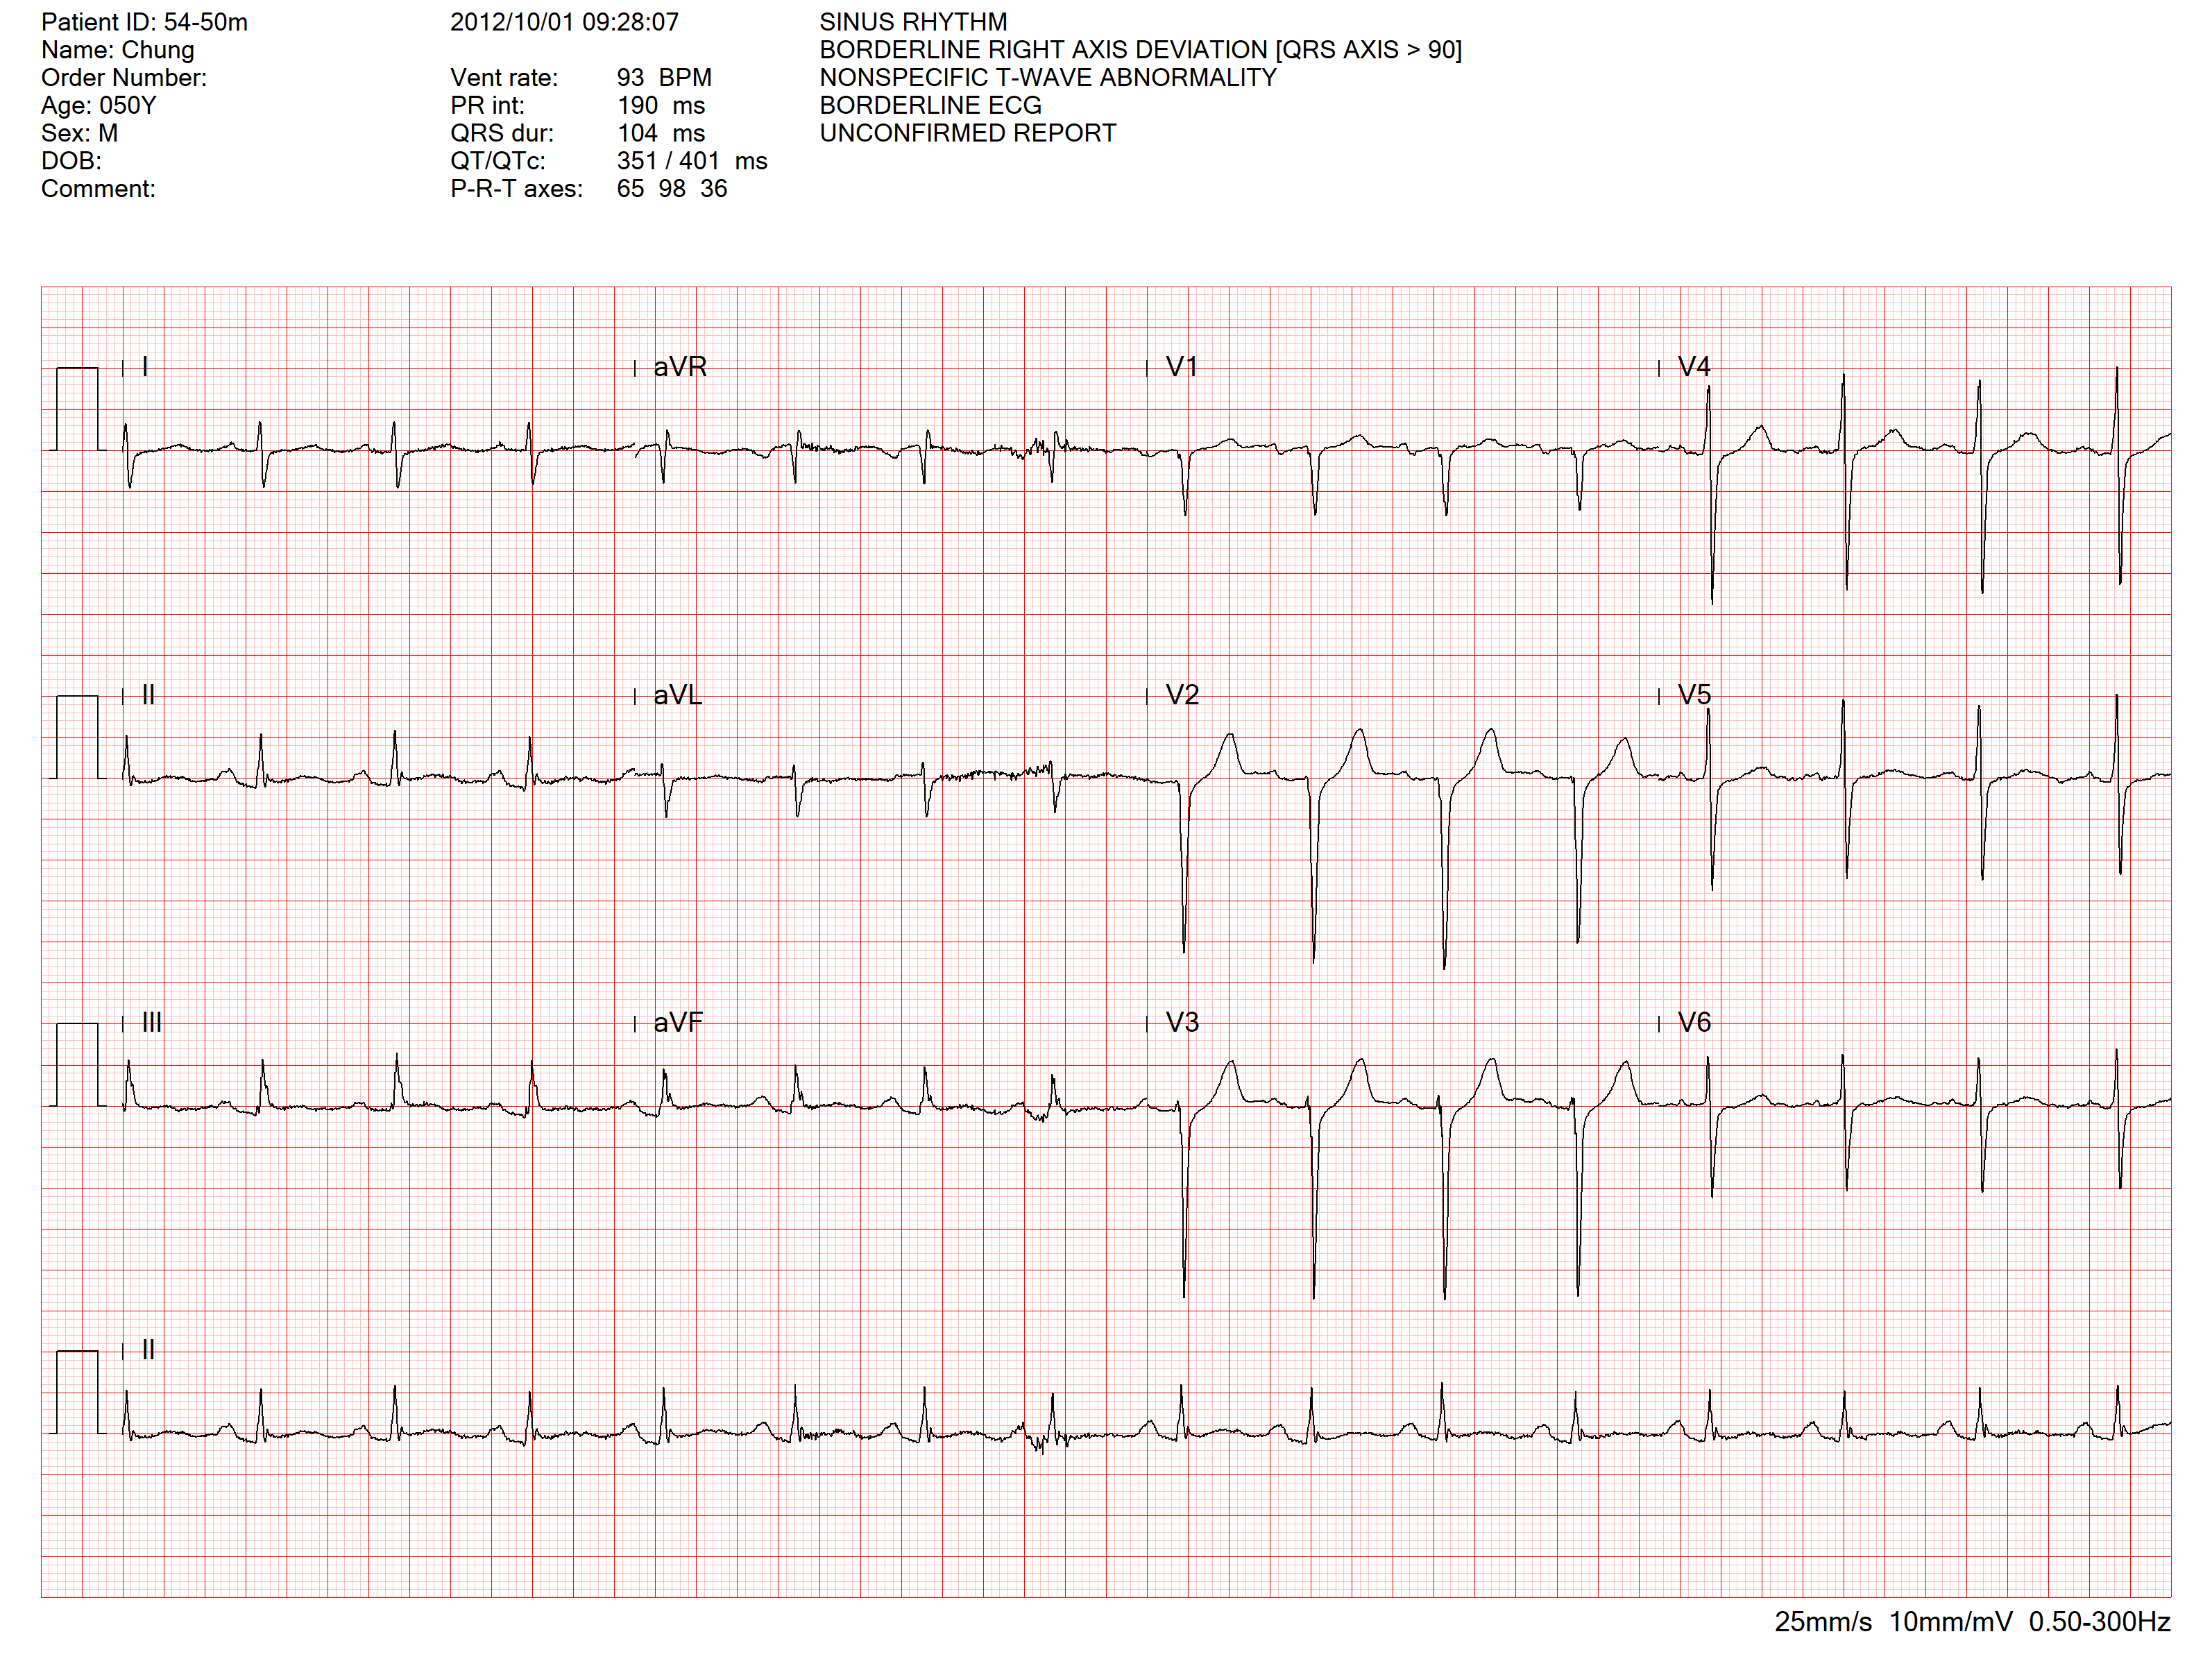

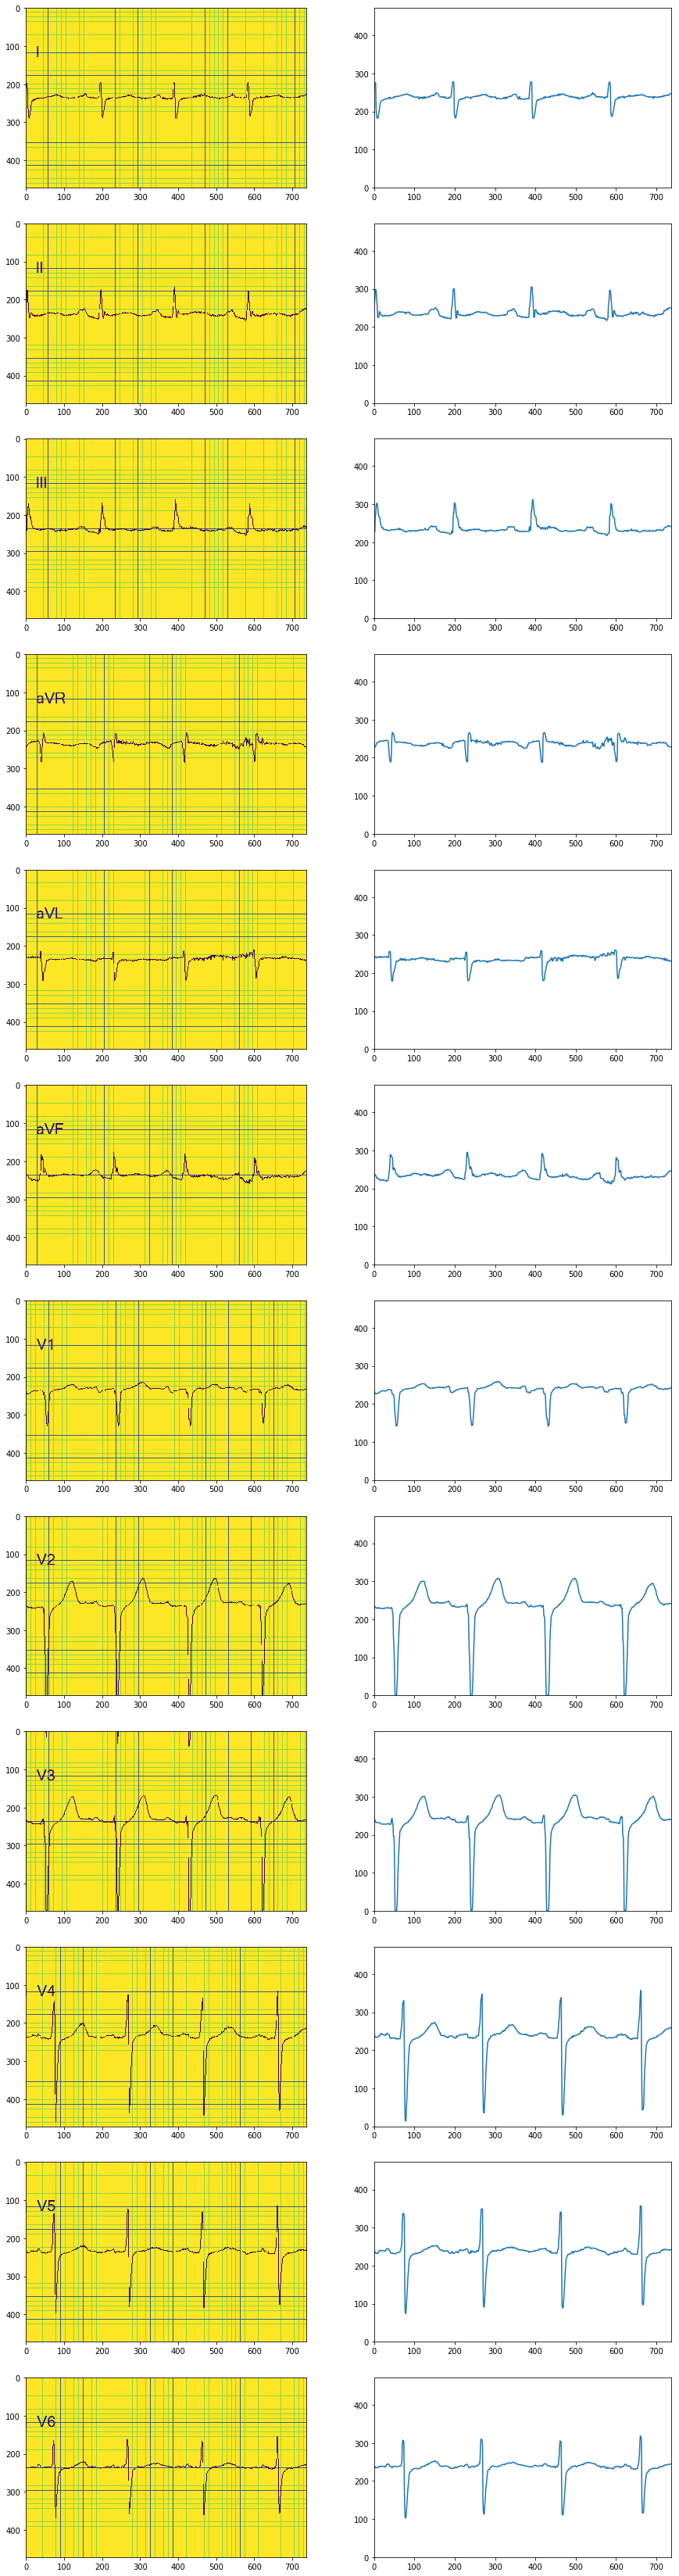

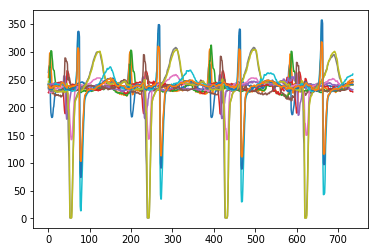

In [21]:
%run -i 'ecg_parser.py'
plt.plot(ecgWave)
plt.show()
